# Germany correlated sampling 

Objective: make a plot of the analysis for Germany, where sampling is based on correlating structure after Nguyen et al. (2020) instead of random sampling.

In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import pygeos as pyg
import sys
import json
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

sys.path.append("../scripts")
sys.path.append("..")
from utils import *
from Europe_utils import *
from visualisations_new import aggregate_results_step1, aggregate_results_step2, percolation_summary, main


In [2]:
config = load_config(file = 'config_eventbased_3.json')
config

{'comment': 'This json file contains the paths to the directories where the in- and output files are located',
 'paths': {'data': WindowsPath('D:/Python/europe_flood_road_disruption/data'),
  'output_data': WindowsPath('D:/Python/europe_flood_road_disruption/data/output'),
  'output_images': WindowsPath('D:/Python/europe_flood_road_disruption/visualisations'),
  'NUTS_shapes': WindowsPath('D:/Europe_trade_disruptions/NUTS-2_shapes/NUTS_2016'),
  'graphs_folder': WindowsPath('D:/Europe_percolation/trails_networks'),
  'preproc_output': WindowsPath('D:/Europe_percolation/event_sampling_vs3/preproc_output'),
  'main_output': WindowsPath('D:/Europe_percolation/event_sampling_vs3/main_output'),
  'logs': WindowsPath('D:/Europe_percolation/event_sampling_vs3/logs')}}

In [3]:
#Add all years to a seperate df
folder = config['paths']['main_output'] / 'germany' / 'finished'
folder.exists()

if 'df' in locals(): del df

for year_csv in tqdm(folder.iterdir()):
    year = year_csv.stem
    if not year_csv.exists():
        raise Exception('File {} does not exist'.format(year_csv))
        
    new_row = pd.read_csv(year_csv,sep=';',index_col=0)
    new_row.index = [int(year)]
    if not 'df' in locals():
        df = new_row
    else:
        df = df.append(new_row)
        
df.sort_index(inplace=True)

df

0it [00:00, ?it/s]

,disrupted,no detour,avg extra time,AoI removed,OD-disrupted,OD-with_detour,with_detour_extra_times,edges_in_graph,edges_in_giant
2,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379
4,0.000000,0.000000,0.000000,NaN,[],[],[],375938,375308
5,35.277383,10.384068,0.471468,NaN,"[""DE30-DE24"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""DE30-DE24"", ""DE30-DEC0"", ""DE30-DE71"", ""DE30-...","[""0.123"", ""0.233"", ""0.251"", ""0.743"", ""0.095"", ...",367428,355982
12,4.267425,0.000000,0.194972,NaN,"[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""0.212"", ""0.042"", ""0.181"", ""0.042"", ""0.045"", ...",375773,375137
18,0.284495,0.000000,0.042156,NaN,"[""DE22-DE12"", ""DE11-DE13""]","[""DE22-DE12"", ""DE11-DE13""]","[""0.024"", ""0.061""]",375788,375107
...,...,...,...,...,...,...,...,...,...
9975,46.799431,0.000000,0.248840,NaN,"[""DE30-DEA1"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""DE30-DEA1"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""0.147"", ""0.532"", ""0.417"", ""0.147"", ""0.147"", ...",374385,373506
9983,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379
9988,1.422475,0.000000,0.030085,NaN,"[""DE22-DEF0"", ""DE22-DE60"", ""DEE0-DEF0"", ""DEE0-...","[""DE22-DEF0"", ""DE22-DE60"", ""DEE0-DEF0"", ""DEE0-...","[""0.028"", ""0.028"", ""0.035"", ""0.035"", ""0.029"", ...",375627,374820
9992,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379


### Need to get some information from scheduled jsons, namely the basin aoi and the inundated AoIs

##### READ which aois are within the country border of Germany for sound statistics
That value corresponds to the maximum x-value
We need to correct for this because some of the floods occur outside germany (but part of their basin is in Germany)

In [4]:
f = config['paths']['data'] / 'sampling_data' / 'aoi_in_germany.json'
with open (f,'r') as f:
    aois_in_germany = json.load(f)
print(len(aois_in_germany),aois_in_germany[0:5], 'etc ...')

2101 [0, 14694, 14744, 14796, 14797] etc ...


In [5]:
df[['nr_basinfloods_100','nr_basinfloods_50','nr_microfloods_100','nr_microfloods_50']] = None
df

folder = config['paths']['main_output'] / 'germany' / 'scheduled'
folder.exists()

for year_json in tqdm(folder.iterdir()):
    with open(year_json) as j:
        s = json.load(j)
        key = list(s['data'].keys())[0]
        #basin_floods = s['data'][year]['microfloods']

        df.at[int(key),'nr_basinfloods_100'] = len([basin_flood for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 100])
        df.at[int(key),'nr_basinfloods_50'] = len([basin_flood for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 50])

        aoi100 = [basin_flood['cell_aois'] for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 100]
        microfloods100_all = list(set([j for i in aoi100 for j in i]))
        microfloods100 = [aoi for aoi in microfloods100_all if aoi in aois_in_germany]
        df.at[int(key),'nr_microfloods_100'] = len(microfloods100)

        aoi50 = [basin_flood['cell_aois'] for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 50]
        microfloods50_all = list(set([j for i in aoi50 for j in i])) #including outside Germany
        microfloods50 = [aoi for aoi in microfloods50_all if aoi in aois_in_germany]
        df.at[int(key),'nr_microfloods_50'] = len(microfloods50)
        
df

0it [00:00, ?it/s]

,disrupted,no detour,avg extra time,AoI removed,OD-disrupted,OD-with_detour,with_detour_extra_times,edges_in_graph,edges_in_giant,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50
2,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379,1,2,9,46
4,0.000000,0.000000,0.000000,NaN,[],[],[],375938,375308,0,1,0,4
5,35.277383,10.384068,0.471468,NaN,"[""DE30-DE24"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""DE30-DE24"", ""DE30-DEC0"", ""DE30-DE71"", ""DE30-...","[""0.123"", ""0.233"", ""0.251"", ""0.743"", ""0.095"", ...",367428,355982,36,45,388,494
12,4.267425,0.000000,0.194972,NaN,"[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""0.212"", ""0.042"", ""0.181"", ""0.042"", ""0.045"", ...",375773,375137,1,3,0,13
18,0.284495,0.000000,0.042156,NaN,"[""DE22-DE12"", ""DE11-DE13""]","[""DE22-DE12"", ""DE11-DE13""]","[""0.024"", ""0.061""]",375788,375107,1,8,1,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,46.799431,0.000000,0.248840,NaN,"[""DE30-DEA1"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""DE30-DEA1"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""0.147"", ""0.532"", ""0.417"", ""0.147"", ""0.147"", ...",374385,373506,7,26,90,326
9983,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379,0,1,0,4
9988,1.422475,0.000000,0.030085,NaN,"[""DE22-DEF0"", ""DE22-DE60"", ""DEE0-DEF0"", ""DEE0-...","[""DE22-DEF0"", ""DE22-DE60"", ""DEE0-DEF0"", ""DEE0-...","[""0.028"", ""0.028"", ""0.035"", ""0.035"", ""0.029"", ...",375627,374820,1,8,6,117
9992,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379,0,1,0,18


In [6]:
df['year'] = df.index

### Prepare plots
Plot 1: timeline with amount of AoI hit per year.

Plot 2ABC: scatter plot (x: AoI combinations, y: disrupted,| avg extra time, no detour)

todo: corrigeren voor punten/AoI? niet in Duitsland?

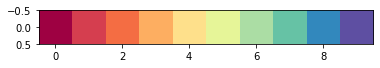

In [7]:
import matplotlib as mpl
#colorscheme
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']
roads_cc = colors[0:5][::-1] #We iterate over the roads in reversed order
roads_lw_cc = [1,0.7,0.5,.3,.3][::-1] #linewidth cycler
nuts_fill = '#abdda4'
nuts_border = '#66c2a5'

length_cols = ['Total_Edge_Length', 'Len_Motorway', 'Len_Trunk', 'Len_Primary', 'Len_Secondary', 'Len_Tertiary']

road_types = ['motorway','trunk','primary','secondary','tertiary']

plt.imshow(to_rgba_array(colors).reshape(1,len(colors),4))
plt.show()


font = {'family' : 'arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
grey = '#444444'
mpl.rcParams.update({'text.color' : grey,
                     'axes.labelcolor' : grey,
                     'axes.titlecolor' : grey,
                     'axes.edgecolor' : grey,
                     'xtick.color': grey, #This is the color of the categories on y- and x-axis
                     'ytick.color': grey                    })

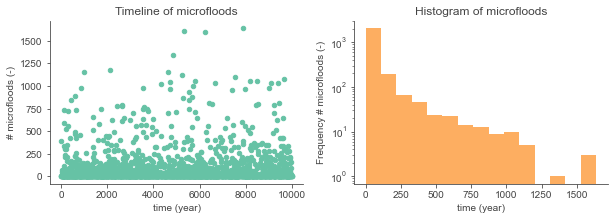

In [8]:
fig,axes = plt.subplots(1,2,figsize=(10,3))

df.plot(x='year',y='nr_microfloods_100',kind='scatter',ax=axes[0],color=colors[7])
df.plot(x='year',y='nr_microfloods_100',kind='hist',ax=axes[1],color=colors[3],bins=15,legend=None)
axes[1].set_yscale('log')

axes[0].set_title('Timeline of microfloods')
axes[0].set_ylabel('# microfloods (-)')
axes[0].set_xlabel('time (year)')

axes[1].set_title('Histogram of microfloods')
axes[1].set_ylabel('Frequency # microfloods (-)')
axes[1].set_xlabel('time (year)')

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [21]:
dest_dir = Path('Germany-sampling')
this_version = 'v3'
name = 'flood_frequency'
fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

### Shading

create summary statistics for the sampling as well to plot bandwidth

In [9]:
df.head(n=8)

,disrupted,no detour,avg extra time,AoI removed,OD-disrupted,OD-with_detour,with_detour_extra_times,edges_in_graph,edges_in_giant,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,year
2,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379,1,2,9,46,2
4,0.000000,0.000000,0.000000,NaN,[],[],[],375938,375308,0,1,0,4,4
5,35.277383,10.384068,0.471468,NaN,"[""DE30-DE24"", ""DE30-DE22"", ""DE30-DEC0"", ""DE30-...","[""DE30-DE24"", ""DE30-DEC0"", ""DE30-DE71"", ""DE30-...","[""0.123"", ""0.233"", ""0.251"", ""0.743"", ""0.095"", ...",367428,355982,36,45,388,494,5
12,4.267425,0.000000,0.194972,NaN,"[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""DEA1-DED4"", ""DEA1-DED2"", ""DE92-DED4"", ""DE22-...","[""0.212"", ""0.042"", ""0.181"", ""0.042"", ""0.045"", ...",375773,375137,1,3,0,13,12
18,0.284495,0.000000,0.042156,NaN,"[""DE22-DE12"", ""DE11-DE13""]","[""DE22-DE12"", ""DE11-DE13""]","[""0.024"", ""0.061""]",375788,375107,1,8,1,127,18
20,5.120910,0.000000,0.058048,NaN,"[""DE30-DEA5"", ""DE24-DE94"", ""DEA1-DE91"", ""DE92-...","[""DE30-DEA5"", ""DE24-DE94"", ""DEA1-DE91"", ""DE92-...","[""0.108"", ""0.056"", ""0.073"", ""0.024"", ""0.056"", ...",375917,375274,0,10,0,167,20
27,0.000000,0.000000,0.000000,NaN,[],[],[],376004,375379,0,2,0,27,27
28,0.000000,0.000000,0.000000,NaN,[],[],[],375893,375243,3,4,16,26,28


In [10]:
column = 'nr_microfloods_100'
dfs = df.sort_values(by=column)
dfs
groups = df.groupby(by=column)

In [11]:
groups.describe().head(n=10)

disrupted                                               \
                       count      mean       std  min       25%       50%   
nr_microfloods_100                                                          
0                     1138.0  0.985483  3.081157  0.0  0.000000  0.000000   
1                       29.0  2.761564  9.121724  0.0  0.000000  0.000000   
2                        1.0  0.000000       NaN  0.0  0.000000  0.000000   
3                       29.0  1.746211  3.517345  0.0  0.000000  0.000000   
4                      113.0  0.694873  2.610193  0.0  0.000000  0.000000   
5                       26.0  3.846154  4.698645  0.0  0.284495  3.129445   
6                       21.0  1.496986  3.791268  0.0  0.000000  0.000000   
7                       11.0  0.129316  0.428892  0.0  0.000000  0.000000   
8                       25.0  4.813656  4.183560  0.0  2.702703  4.267425   
9                       27.0  4.609873  8.124625  0.0  0.000000  0.284495   

                                        no detour       ... edges_in_giant  \
                         75%        max     count mean  ...            75%   
nr_microfloods_100                                      ...                  
0                   0.000000  23.755334    1138.0  0.0  ...       375379.0   
1                   0.000000  45.234708      29.0  0.0  ...       375379.0   
2                   0.000000   0.000000       1.0  0.0  ...       375379.0   
3                   2.987198  14.509246      29.0  0.0  ...       375342.0   
4                   0.000000  15.362731     113.0  0.0  ...       375379.0   
5                   4.694168  16.500711      26.0  0.0  ...       375334.5   
6                   1.422475  16.358464      21.0  0.0  ...       375379.0   
7                   0.000000   1.422475      11.0  0.0  ...       375379.0   
8                   4.836415  15.362731      25.0  0.0  ...       375277.0   
9                   4.267425  33.001422      27.0  0.0  ...       375364.5   

                                year                                    \
                         max   count         mean          std     min   
nr_microfloods_100                                                       
0                   375379.0  1138.0  4959.508787  2901.395076     4.0   
1                   375379.0    29.0  5132.172414  2995.884821    18.0   
2                   375379.0     1.0  7086.000000          NaN  7086.0   
3                   375379.0    29.0  5371.931034  2744.604433   874.0   
4                   375379.0   113.0  4585.274336  2878.737736    37.0   
5                   375379.0    26.0  4456.307692  2363.464267   182.0   
6                   375379.0    21.0  4960.476190  3109.575946   413.0   
7                   375379.0    11.0  4917.727273  3378.778303  1225.0   
8                   375379.0    25.0  4847.400000  2799.123583   240.0   
9                   375379.0    27.0  5732.851852  2867.837026     2.0   

                                                      
                        25%     50%      75%     max  
nr_microfloods_100                                    
0                   2390.75  5037.0  7446.25  9997.0  
1                   2084.00  5790.0  7642.00  9284.0  
2                   7086.00  7086.0  7086.00  7086.0  
3                   3246.00  5449.0  8046.00  9373.0  
4                   2208.00  4199.0  7085.00  9883.0  
5                   2946.25  4269.5  6220.75  9219.0  
6                   2937.00  4539.0  7660.00  9988.0  
7                   2248.00  4189.0  7938.50  9816.0  
8                   2792.00  3977.0  6954.00  9517.0  
9                   3531.00  6815.0  8091.50  9843.0  

[10 rows x 56 columns]

Conclusion: it is not possible to make uniform statistics of these, because the groups are very different in size...

### Disrupted routes plot

In [12]:
### Load data of regular analysis
config_reg = load_config(file='config.json')
df_ref,df_abs,df_rel = main(config_reg)

 -------- main() starting --------
Succesfully loaded source file as dataframe, with columns:
Index(['AoI combinations', 'experiment', 'disrupted', 'no detour',
       'avg extra time', 'AoI removed', 'OD-disrupted', 'OD-with_detour',
       'with_detour_extra_times', 'edges_in_graph', 'edges_in_giant',
       'country'],
      dtype='object')
Available for 30 countries
Grouping per AoI-country combination
 -------- main() finished --------


In [13]:
from visualisations_new import process_no_detour, no_detour_aggregated_lineplot
#LOAD AND PROCESS NO DETOUR RESULTS
no_dt_abs, no_dt_rel = process_no_detour(df_ref)

 -------- Process_no_detour() finished --------


(<Figure size 720x288 with 2 Axes>,
 <AxesSubplot:xlabel="Number of combinations of micro-floods (AoI's)", ylabel='% routes without detour'>)

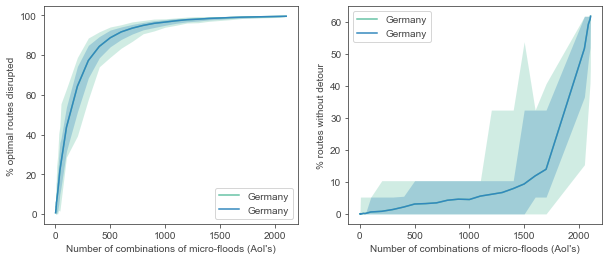

In [14]:
### Background layer: plot of Germany
from visualisations_new import aggregated_lineplot_new

#fig,axes = plt.subplots(1,3,figsize=(15,3))
fig,axes = plt.subplots(1,2,figsize=(10,4))

aggregated_lineplot_new(df_abs,['germany'],fill_between=('min','max'),save=False,fig=fig,ax=axes[0],clrs=[colors[7]])
aggregated_lineplot_new(df_abs,['germany'],fill_between=('q_05','q_95'),save=False,fig=fig,ax=axes[0],clrs=[colors[8]])

no_detour_aggregated_lineplot(no_dt_abs,['germany'],fill_between=('min','max'),save=False,fig=fig,ax=axes[1],clrs=[colors[7]])
no_detour_aggregated_lineplot(no_dt_abs,['germany'],fill_between=('q_05','q_95'),save=False,fig=fig,ax=axes[1],clrs=[colors[8]])

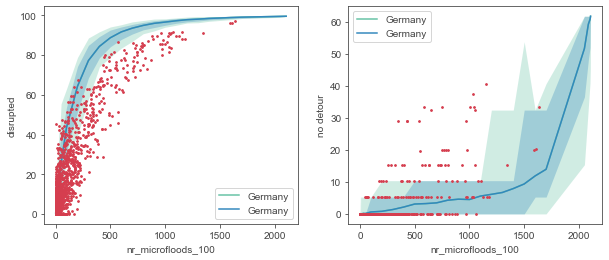

In [15]:
df.plot(x='nr_microfloods_100',y='disrupted',kind='scatter',color=colors[1],ax=axes[0],s=3,zorder=4)
df.plot(x='nr_microfloods_100',y='no detour',kind='scatter',color=colors[1],ax=axes[1],s=3,zorder=4)
fig

In [16]:
### Todo: draw trendline
groupby = 'nr_microfloods_100'

mean_groups = df.groupby(by=groupby).mean()
mean_groups.head(n=3)

,disrupted,no detour,avg extra time,AoI removed,edges_in_graph,edges_in_giant,year
nr_microfloods_100,,,,,,,
0,0.985483,0.0,0.024024,NaN,375969.785589,375336.826889,4959.508787
1,2.761564,0.0,0.049047,NaN,375886.862069,375242.965517,5132.172414
2,0.000000,0.0,0.000000,NaN,376004.000000,375379.000000,7086.000000


In [17]:
# #Disruption preferred routes trendline
# ax = axes[0]
# ax.plot(mean_groups.index,mean_groups['disrupted'])

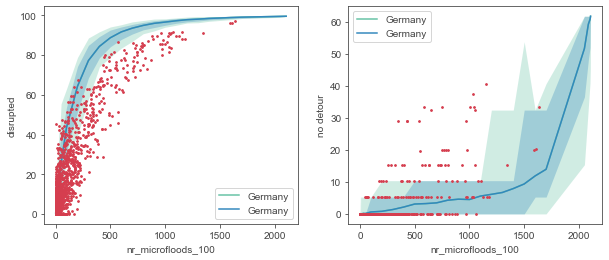

In [18]:
fig

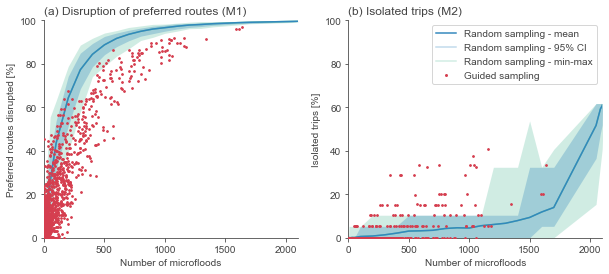

In [19]:
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlabel(xlabel='Number of microfloods')
    ax.set_ylim(0,100)
    ax.set_xlim(0,2100)
    
# axes[2].tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left = False,
#     right = False,
#     labelbottom=False,
#     labelleft=False) # labels along the bottom edge are off
# axes[2].set_xlabel(None)

axes[0].set_ylabel('Preferred routes disrupted [%]')
axes[1].set_ylabel('Isolated trips [%]')    

axes[0].set_title('(a) Disruption of preferred routes (M1)',loc='left')
axes[1].set_title('(b) Isolated trips (M2)',loc='left')



# PREPARE LEGEND
handles0 = []
handles0.append(Line2D([0], [0], marker=None, color=colors[8], label='Random sampling - mean'))
handles0.append(Line2D([0], [0], marker=None, color=colors[8], alpha=0.3, label='Random sampling - 95% CI'))
handles0.append(Line2D([0], [0], marker=None, color=colors[7], alpha=0.3, label='Random sampling - min-max'))
handles0.append(Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[1], label='Guided sampling', markeredgecolor='none',markersize=3))

axes[0].legend().remove()
axes[1].legend(handles=handles0,title=None,loc='upper right')

fig

In [22]:
dest_dir = Path('Germany-sampling')
name = 'compare_to_random'
fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

In [23]:
axes[0].set_xlim(0,100)
axes[0].set_ylim(0,40)
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,40)
fig
dest_dir = Path('Germany-sampling')
name = 'compare_to_random_detail'
fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

### count # events above threshold

In [97]:
threshold = 80 #%
Type = 'disrupted'


def count_events_above_threshold(df,Type,threshold):
    """
    E.g. df = df, Type = 'disrupted', threshold = 80
    returns number events above that threshold
    
    """
    sel = df.loc[df[Type] >= threshold]
    return sel.shape[0]

sel = count_events_above_threshold(df,Type,threshold)

x_values = range(0,101)
freq_disrupted = [count_events_above_threshold(df,'disrupted',x) / 10_000 for x in x_values]

freq_nodetour = [count_events_above_threshold(df,'no detour',x) / 10_000 for x in x_values]


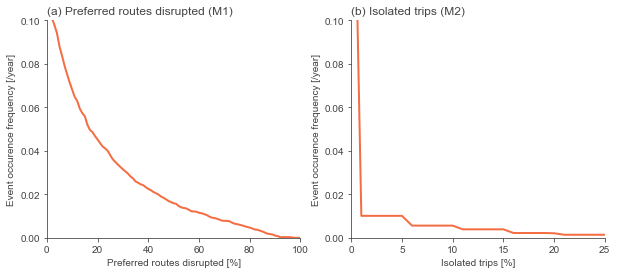

In [98]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
ax = axes[0]
ax.plot(x_values,freq_disrupted,c=colors[2],lw=2)
ax.set_ylim(0,0.10)
ax.set_xlim(0,100)
ax.set_title('(a) Preferred routes disrupted (M1)',loc='left')
ax.set_xlabel('Preferred routes disrupted [%]')
ax.set_ylabel('Event occurence frequency [/year]')

ax = axes[1]

ax.plot(x_values,freq_nodetour,c=colors[2],lw=2)
ax.set_ylim(0,0.10)
ax.set_xlim(0,25)
ax.set_title('(b) Isolated trips (M2)',loc='left')
ax.set_xlabel('Isolated trips [%]')
ax.set_ylabel('Event occurence frequency [/year]')



for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [99]:
dest_dir = Path('Germany-sampling')
name = 'frequency'
#fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
#fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

In [100]:
count_events_above_threshold(df,'disrupted',50)

159

### Values for in the paper

In [101]:
print(freq_disrupted[50],freq_disrupted[80])
print(freq_nodetour[5],freq_nodetour[10])

0.0159 0.0047
0.0101 0.0056


In [102]:
#return period
print(1/freq_disrupted[50],1/freq_disrupted[80])
print(1/freq_nodetour[5],1/freq_nodetour[10])

62.893081761006286 212.7659574468085
99.00990099009901 178.57142857142858


### Select some extreme values

In [103]:
Sort_disr = df.sort_values(by='disrupted',ascending=False)
Sort_disr.iloc[0:10]

,disrupted,no detour,avg extra time,AoI removed,OD-disrupted,OD-with_detour,with_detour_extra_times,edges_in_graph,edges_in_giant,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,year,microfloods_50
7892,97.155050,33.285917,3.277244,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE80"", ""DE30-...","[""7.871"", ""7.044"", ""0.818"", ""2.315"", ""6.222"", ...",341898,287720,120,124,1638,1680,7892,NaN
5338,96.159317,20.199147,1.792470,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE80"", ""DE30-...","[""1.286"", ""2.940"", ""0.818"", ""1.834"", ""0.796"", ...",346787,315860,123,130,1610,1727,5338,NaN
6224,96.159317,20.056899,3.747390,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE80"", ""DE30-...","[""8.076"", ""7.249"", ""0.818"", ""2.315"", ""6.427"", ...",344601,310297,115,121,1591,1635,6224,NaN
9648,91.749644,10.384068,1.306759,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE50"", ""DE30-...","[""0.654"", ""2.463"", ""0.513"", ""0.467"", ""1.652"", ...",360964,356836,85,102,1076,1306,9648,NaN
4631,91.749644,40.682788,2.187211,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE50"", ""DE30-...","[""0.134"", ""0.225"", ""0.156"", ""0.010"", ""0.315"", ...",348689,270276,98,110,1155,1360,4631,NaN
4730,91.322902,33.285917,1.354846,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE80"", ""DE30-...","[""0.335"", ""0.827"", ""0.818"", ""1.418"", ""0.796"", ...",350712,300218,88,98,1038,1177,4730,NaN
4862,91.322902,15.362731,1.984859,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE80"", ""DE30-...","[""7.483"", ""6.629"", ""0.818"", ""2.315"", ""6.427"", ...",354107,338540,102,114,1344,1500,4862,NaN
5820,91.180654,32.432432,1.868169,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE50"", ""DE30-...","[""0.033"", ""2.087"", ""0.156"", ""0.010"", ""0.315"", ...",349870,298763,92,93,1054,1071,5820,NaN
7981,90.896159,28.876245,1.594305,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE22"", ""DE30-...","[""DE30-DE24"", ""DE30-DE22"", ""DE30-DE50"", ""DE30-...","[""0.033"", ""0.745"", ""0.079"", ""0.240"", ""1.556"", ...",351797,301778,78,90,964,1150,7981,NaN
8183,90.753912,15.220484,1.240416,NaN,"[""DE30-DE24"", ""DE30-DEA1"", ""DE30-DE92"", ""DE30-...","[""DE30-DE24"", ""DE30-DE92"", ""DE30-DE22"", ""DE30-...","[""0.195"", ""2.612"", ""0.052"", ""0.818"", ""2.315"", ...",355710,323792,74,85,1049,1132,8183,NaN


In [104]:
topyears_disr = list(Sort_disr[0:3].index)
topyears_disr

[7892, 5338, 6224]

#### From here to below, not updated in version 2 (14/3/2022)

### Look into some extreme events for relatively low aois

In [105]:
threshold = (20,8)
x_values = list(range(0,21))
y_values = [(8/20)*x for x in x_values]

df2['threshold'] = df2['AoI combinations'].apply(lambda x: ((8/20)*x))
df2['above'] = df2['disrupted'] >= df2['threshold']

NameError: name 'df2' is not defined

<AxesSubplot:xlabel='AoI combinations', ylabel='disrupted'>

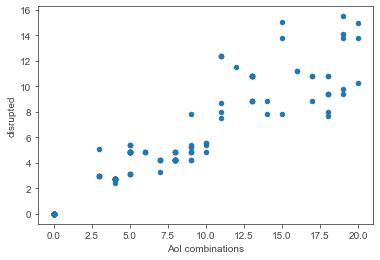

In [33]:
df_above = df2.loc[df2['above']]
df_above.plot(x='AoI combinations',y='disrupted',kind='scatter')

In [43]:
AoI_in_df_above = []
for value in df_above['AoI removed']:
    AoI_in_df_above.extend(value)

In [ ]:
from collections import Counter
c = Counter(AoI_in_df_above)
c.most_common()

### Compare statistics of both distributions

In [85]:
gs = groups.size()
gs.iloc[0:50]

nr_microfloods_100
0     99
1      1
2      1
4      5
5      6
6     20
7      3
8      5
9      4
10     3
11     6
12     4
13     3
14     2
15     1
16     3
17     4
18     1
19     1
21     3
22     3
24     2
25     1
26     1
28     1
29     1
30     4
31     2
32     1
33     3
34     1
35     1
36     1
37     3
38     4
39     1
40     3
41     3
44     3
45     2
46     1
47     1
48     1
49     5
50     5
51     3
52     2
53     1
54     1
55     1
dtype: int64

In [93]:
x = groups['disrupted'].describe()
x.head(n=8)

,count,mean,std,min,25%,50%,75%,max
nr_microfloods_100,,,,,,,,
0,99.0,4.324899,5.558841,0.000000,0.000000,2.987198,6.401138,27.453770
1,1.0,1.422475,NaN,1.422475,1.422475,1.422475,1.422475,1.422475
2,1.0,0.284495,NaN,0.284495,0.284495,0.284495,0.284495,0.284495
4,5.0,4.523471,5.986576,0.000000,0.000000,2.987198,5.120910,14.509246
5,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,20.0,2.389758,3.601449,0.000000,0.000000,0.000000,4.836415,11.095306
7,3.0,5.547653,9.608817,0.000000,0.000000,0.000000,8.321479,16.642959
8,5.0,1.166430,1.861215,0.000000,0.000000,0.000000,1.564723,4.267425


In [117]:
y = df_ref.loc[df_ref['country']=='Germany']
y = y.groupby('AoI combinations').median()
y.head()

,disrupted,avg extra time,no detour,AoI relative combinations
AoI combinations,,,,
1,0.000000,0.000000,0.0,0.047483
2,0.000000,0.000000,0.0,0.094967
3,1.280228,0.000613,0.0,0.142450
4,1.991465,0.000988,0.0,0.189934
5,2.560455,0.001433,0.0,0.237417


In [128]:
#interpolate all median values for all whole integers 0tm100

values = list(range(0,101))
col = 'disrupted'
y['AoI combinations'] = y.index
arr = y[['AoI combinations',col]].to_numpy()
arr = np.insert(arr,obj=0,values=np.array([0,0]),axis=0) #add 0,0 point
assert sorted(arr[:,0] == arr[:,0]) #check if list is sorted (needed for interpolation function)
interpolated = np.interp(x=values,xp=arr[:,0],fp=arr[:,1])
interpolated

array([ 0.        ,  0.        ,  0.        ,  1.2802276 ,  1.99146515,
        2.56045519,  3.84068279,  4.40967283,  4.33854908,  6.11664296,
        7.25462304,  7.85206259,  8.44950213,  9.04694168,  9.64438122,
       10.24182077, 10.83926031, 11.43669986, 12.0341394 , 12.63157895,
       13.22901849, 13.80512091, 14.38122333, 14.95732575, 15.53342816,
       16.10953058, 16.685633  , 17.26173542, 17.83783784, 18.41394026,
       18.99004267, 19.58036984, 20.17069701, 20.76102418, 21.35135135,
       21.94167852, 22.53200569, 23.12233286, 23.71266003, 24.3029872 ,
       24.89331437, 25.52631579, 26.15931721, 26.79231864, 27.42532006,
       28.05832148, 28.6913229 , 29.32432433, 29.95732575, 30.59032717,
       31.22332859, 31.60312945, 31.9829303 , 32.36273116, 32.74253201,
       33.12233286, 33.50213372, 33.88193457, 34.26173542, 34.64153628,
       35.02133713, 35.40113798, 35.78093884, 36.16073969, 36.54054054,
       36.9203414 , 37.30014225, 37.6799431 , 38.05974396, 38.43

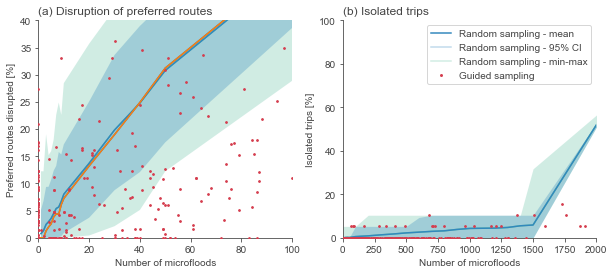

In [127]:
fig
axes[0].plot(values,interpolated)
fig

In [138]:
dfs = df.loc[df['nr_microfloods_100'] <= 100]
dfs['random_median'] = dfs['nr_microfloods_100'].apply(lambda x: interpolated[x])
dfs

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
4,4.0,0.000000,0.000000,0.0,0,1,0,4,0.000000
12,12.0,8.819346,0.025458,0.0,1,3,0,18,0.000000
18,18.0,0.284495,0.000120,0.0,1,8,2,450,0.000000
20,20.0,5.120910,0.002973,0.0,0,10,0,220,0.000000
28,28.0,0.000000,0.000000,0.0,3,4,39,51,24.302987
...,...,...,...,...,...,...,...,...,...
3471,3471.0,3.129445,0.002886,0.0,0,2,0,18,0.000000
3490,3490.0,0.000000,0.000000,0.0,0,2,0,372,0.000000
3493,3493.0,11.806543,0.013225,0.0,5,8,45,434,28.058321
3510,3510.0,21.337127,0.135843,0.0,4,14,74,357,40.338549


In [140]:
dfs_above = dfs.loc[dfs['disrupted'] > dfs['random_median']]
dfs_above

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
12,12.0,8.819346,0.025458,0.0,1,3,0,18,0.000000
18,18.0,0.284495,0.000120,0.0,1,8,2,450,0.000000
20,20.0,5.120910,0.002973,0.0,0,10,0,220,0.000000
60,60.0,5.120910,0.002973,0.0,0,1,0,4,0.000000
94,94.0,24.466572,0.041017,0.0,1,12,17,296,11.436700
...,...,...,...,...,...,...,...,...,...
3277,3277.0,5.974395,0.044948,0.0,0,8,0,83,0.000000
3329,3329.0,46.088193,0.112505,0.0,4,36,74,485,40.338549
3395,3395.0,8.819346,0.025458,0.0,1,4,12,42,8.449502
3428,3428.0,16.927454,0.041948,0.0,0,5,0,60,0.000000


In [142]:
dfs_below = dfs.loc[dfs['disrupted'] <= dfs['random_median']] 
dfs_below

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
4,4.0,0.000000,0.000000,0.0,0,1,0,4,0.000000
28,28.0,0.000000,0.000000,0.0,3,4,39,51,24.302987
30,30.0,25.889047,0.061379,0.0,5,13,61,265,35.401138
35,35.0,34.850640,0.082849,0.0,10,20,97,196,49.073969
36,36.0,0.000000,0.000000,0.0,0,1,0,6,0.000000
...,...,...,...,...,...,...,...,...,...
3464,3464.0,12.944523,0.022142,0.0,3,6,22,75,14.381223
3490,3490.0,0.000000,0.000000,0.0,0,2,0,372,0.000000
3493,3493.0,11.806543,0.013225,0.0,5,8,45,434,28.058321
3510,3510.0,21.337127,0.135843,0.0,4,14,74,357,40.338549


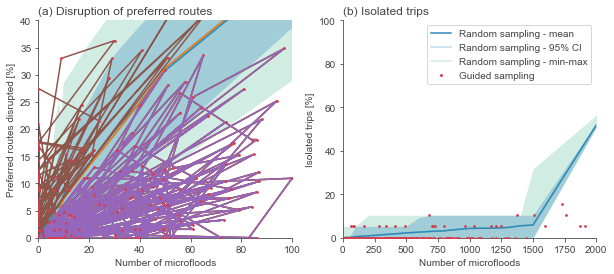

In [145]:
axes[0].plot(dfs_below['nr_microfloods_100'],dfs_below['disrupted'])
axes[0].plot(dfs_above['nr_microfloods_100'],dfs_above['disrupted'])
fig

In [146]:
91/281

0.3238434163701068

In [147]:
190/281

0.6761565836298933

# same thing for isolated trips

In [149]:
values = list(range(0,1501))
col = 'no detour'
y['AoI combinations'] = y.index
arr = y[['AoI combinations',col]].to_numpy()
arr = np.insert(arr,obj=0,values=np.array([0,0]),axis=0) #add 0,0 point
assert sorted(arr[:,0] == arr[:,0]) #check if list is sorted (needed for interpolation function)
interpolated = np.interp(x=values,xp=arr[:,0],fp=arr[:,1])
interpolated

array([0.        , 0.        , 0.        , ..., 5.26315789, 5.26315789,
       5.26315789])